Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip cancut the data size by a large amount, as the number of trips:
${n \choose 2}^2 $ (choosing pickups and dropoffs). 

In [20]:
from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import agg_on_trips
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
sns.set()

import xgboost as xgb

from joblib import dump, load
from sklearn.linear_model import LinearRegression

#taxi_linmod = load('taxi_lin_model.joblib')
taxi_treemod = xgb.Booster()
taxi_treemod.load_model("taxi_xgb_full")

#tnp_linmod = load('tnp_lin_model.joblib')
tnp_treemod = xgb.Booster()
tnp_treemod.load_model("tnp_xgb_full")


data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

In [2]:
X = load_hdf(data["path"]+data["rideshare"],100)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values)

model_preds = tnp_treemod.predict(dtest)
model_preds.size

3047211

In [3]:
rideshare = load_hdf(data["path"]+data["rideshare"],100)
rideshare.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,Final_Fare,l2_dist_km,x_dist_km,y_dist_km,bearing,bAirport,day_of_wk,hour
6283605,1913.0,6.7,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,17.50,7.881464,4.808806,6.242793,-142.361378,False,5,0
10327851,1335.0,5.4,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,15.00,5.462890,1.120689,5.346614,168.152913,False,1,8
581229,1560.0,5.3,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,10.67,6.649193,2.368313,6.212725,-159.115063,False,6,14
10148217,590.0,5.9,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,12.50,4.664751,2.201044,4.113162,-28.136520,False,1,22
1776825,1126.0,4.8,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,5.00,4.316367,2.606686,3.440859,-37.129196,False,3,15


In [4]:
name_mapping = {'Pickup_Centroid_Latitude': 'latp',
                 'Dropoff_Centroid_Latitude': 'latd',
                 'Pickup_Centroid_Longitude': 'longp',
                 'Dropoff_Centroid_Longitude': 'longd'}
    
rideshare.rename(index=str, columns = name_mapping, inplace=True)
locs = list(name_mapping.values())

In [5]:
for coord in locs:
    print(rideshare[coord].nunique())

873
875
872
874


So there are about 900 unique lat/longs giving ~ 500k trip combinations.

In [6]:
# total distinct rides:
900**2/2

405000.0

#### Grouping by rides:

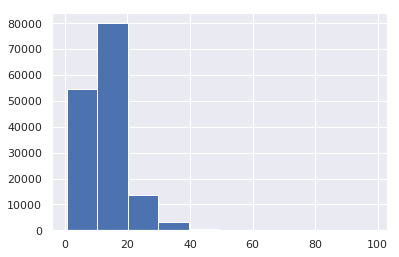

In [7]:
rideshare.groupby(["latp","longd"]).Final_Fare.mean().hist()

In [8]:
def find_boundary(df, padding = 0.001):
    topleft = (max(df.latp.max(),df.latd.max())+padding,min(df.longp.min(),df.longd.min())-padding)
    bottomright = (min(df.latp.min(),df.latd.min())-padding,max(df.longp.max(),df.longd.max())+padding)
    return topleft, bottomright

def coord_bins(df, n = 50):
    """Generate the grid from the lat and long."""
    # TODO: consider non-rectangular grid
    topleft, bottomright = find_boundary(df)
    lat_axis = np.linspace(bottomright[0],topleft[0],n)
    long_axis = np.linspace(topleft[1],bottomright[1],n)
    return lat_axis, long_axis

#def bin_densities(df, lat_axis,long_axis):
 #   df[(df.latp < lat_axis[0] & df.latp < lat_axis[1]]
    

def cut_along_lat_long(df, locs, n_bins = 100):
    labels = np.arange(n_bins-1)
    mapping = {loc:loc + "_b" for loc in locs}
    lat_axis, long_axis = coord_bins(df, n_bins)
    
    for lat in locs[0:2]:
        df[mapping[lat]] = pd.cut(df[lat], bins = lat_axis,labels = labels, retbins=False)

    for long in locs[2:]:
        df[mapping[long]] = pd.cut(df[long], bins = long_axis,labels = labels, retbins=False)
        
    df['path'] = list(zip(zip(df.latp_b,df.longp_b), zip(df.latd_b,df.longd_b)))
    

The way we have done this, there are a lot of 
trips with very few instances. Probably should use
some sort of adaptive grid. I think the simplest 

In [9]:
#lata, longa = coord_bins(rideshare, n = 10)
#rideshare.groupby('path').Trip_Seconds.count().hist(bins = 100, range = (0,100), log = True)

In [10]:
cut_along_lat_long(rideshare, locs, n_bins = 20)

In [11]:
# total unique trips with binning above
print(rideshare.groupby('path').Trip_Miles.count().count())

16589


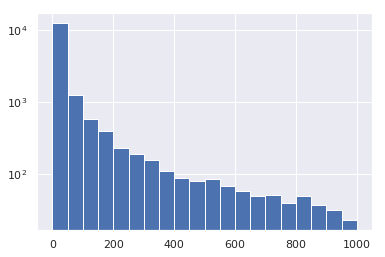

In [12]:
rideshare.groupby('path').Final_Fare.count().hist(bins = 20, range = (0,1000),log = True)

Prints the number of unique trips at this binsize
150k is about the max for the tnp_test data, we know the max possible based on the input data binning
s 400k. We need some balance of bin size between having enough data to show the user a histogram and accuracy.

issue: trip miles has somewhat significant deviation from each other even with fine binning... shared rides?

In [13]:
rideshare.groupby('path').count().mean()

Trip_Seconds              183.688649
Trip_Miles                183.688649
Pickup_Community_Area     183.688649
Dropoff_Community_Area    183.688649
Shared_Trip_Authorized    183.688649
latp                      183.688649
longp                     183.688649
latd                      183.688649
longd                     183.688649
vel_mph                   183.688649
Final_Fare                183.688649
l2_dist_km                183.688649
x_dist_km                 183.688649
y_dist_km                 183.688649
bearing                   183.688649
bAirport                  183.688649
day_of_wk                 183.688649
hour                      183.688649
latp_b                    183.688649
latd_b                    183.688649
longp_b                   183.688649
longd_b                   183.688649
dtype: float64

25


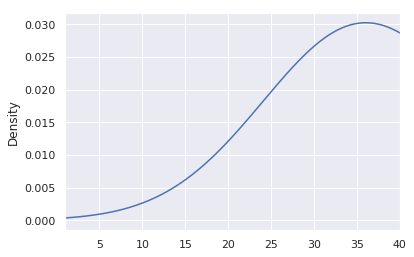

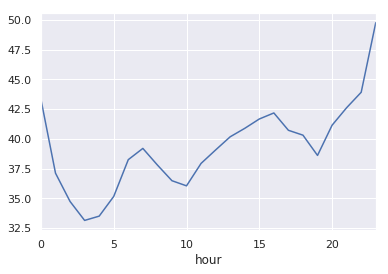

In [14]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),100)]['path'].values

for i,test_path in enumerate(test_paths):
    if rideshare[rideshare.path == test_path].Final_Fare.std() > 5:
        if rideshare[rideshare.path == test_path].Final_Fare.count() > 5000:
            print(i)
            ax = rideshare[rideshare.path == test_path].Final_Fare.plot.kde(1)
            ax.set_xlim([1,40])
            plt.show()
            plt.show()
            rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.mean().plot()
            plt.show()
    

TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

In [15]:
from matplotlib import animation, rc
test_path

((11, 10), (11, 13))

In [16]:
# let's just say a trip is a single row of the dataframe
def single_pt_estimate(trip):
    # Super crude way of formatting the data
    X = trip.drop("Final_Fare").values[:-5]
    print(trip.values.reshape(1,-1))
    t = xgb.DMatrix(X.reshape(1,-1))
    return tnp_treemod.predict(t)

#start, end are lat/long pairs
def ride_summary(df,path, hour = 0):#start,end):
    #trip = find_bin(start,end)
    all_rides = df[df.path == path]
    trip = all_rides.iloc[0]
    trip['hour'] = hour
    estimate = single_pt_estimate(trip)
    return estimate
    
    


In [17]:
estimates =  [ride_summary(rideshare, test_path,i) for i in range(24)]

/home/isaac/anaconda3/envs/dinc_proj/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[[847.0 3.6 27.0 28.0 True 41.875966299999995 -87.6937939017
  41.8679024175 -87.6429586652 15.301063 5.0 4.303612158103447
  4.208899629707405 0.8966640897290472 102.00879754419174 False 4 0 11 11
  10 13 ((11, 10), (11, 13))]]
[[847.0 3.6 27.0 28.0 True 41.875966299999995 -87.6937939017
  41.8679024175 -87.6429586652 15.301063 5.0 4.303612158103447
  4.208899629707405 0.8966640897290472 102.00879754419174 False 4 1 11 11
  10 13 ((11, 10), (11, 13))]]
[[847.0 3.6 27.0 28.0 True 41.875966299999995 -87.6937939017
  41.8679024175 -87.6429586652 15.301063 5.0 4.303612158103447
  4.208899629707405 0.8966640897290472 102.00879754419174 False 4 2 11 11
  10 13 ((11, 10), (11, 13))]]
[[847.0 3.6 27.0 28.0 True 41.875966299999995 -87.6937939017
  41.8679024175 -87.6429586652 15.301063 5.0 4.303612158103447
  4.208899629707405 0.8966640897290472 102.00879754419174 False 4 3 11 11
  10 13 ((11, 10), (11, 13))]]
[[847.0 3.6 27.0 28.0 True 41.875966299999995 -87.6937939017
  41.8679024175 -87.642

In [18]:
estimates

[array([6.73125], dtype=float32),
 array([6.708779], dtype=float32),
 array([6.974792], dtype=float32),
 array([7.125037], dtype=float32),
 array([7.5820727], dtype=float32),
 array([7.2455506], dtype=float32),
 array([6.58825], dtype=float32),
 array([6.3338156], dtype=float32),
 array([6.3338156], dtype=float32),
 array([6.3161964], dtype=float32),
 array([6.3547406], dtype=float32),
 array([6.485228], dtype=float32),
 array([6.50678], dtype=float32),
 array([6.50678], dtype=float32),
 array([6.5581326], dtype=float32),
 array([6.464664], dtype=float32),
 array([6.5758834], dtype=float32),
 array([6.657537], dtype=float32),
 array([6.686455], dtype=float32),
 array([6.686455], dtype=float32),
 array([6.7606716], dtype=float32),
 array([6.8543086], dtype=float32),
 array([6.764467], dtype=float32),
 array([6.8069677], dtype=float32)]

ValueError: `dataset` input should have multiple elements.

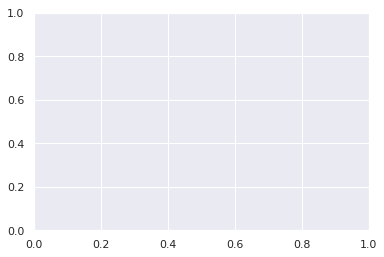

In [19]:
test_path = test_paths[74]
axes = rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.plot.kde(.5)
#for i, ax in enumerate(axes):
#    ax.axvline(estimates[i], color='k', linestyle='--')

In [ ]:
def get_plot_data(axes):
    xs = []
    ys = []
    for i,ax in enumerate(axes):
        line = ax.lines[i]
        xs.append(line.get_xdata())
        ys.append(line.get_ydata())
    return xs, ys
    
    

In [ ]:
from matplotlib import animation, rc

rc('animation', html='html5')
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 20, 60))
ax.set_ylim((0, .1))
ax.set_xlabel('Fare $', size = 16)
ax.set_ylabel('Trip Density', size = 16)


line, = ax.plot([], [], lw=5)
time_template = 'Hours Since Midnight = %.3s'
time_text = ax.text(0.4, 0.8, '', transform=ax.transAxes, size = 'x-large')
dt = 1

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line,time_text


# animation function. This is called sequentially
def animate(i):
    x = xs[i]
    y = ys[i]
    line.set_data(x, y)
    rgb = (i/24, 0.2, 0.5)
    time_text.set_text(time_template % (i*dt))
    time_text.set_color(rgb)
    ax.axvline(estimates[i], color=rgb, linestyle='--')
    return line,time_text

In [ ]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
xs, ys = get_plot_data(axes)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=24, interval=1000, blit=True)

In [ ]:
anim

In [ ]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),10)]['path'].values

In [ ]:
animation.writers?

In [ ]:
import xgboost as xgb

In [ ]:
# get DF indices corresponding to path
indices =rideshare[rideshare["path"] == test_paths[0]].index.values.astype(int).tolist()

In [ ]:
# get predictions for those indices fro the model
sample = X.loc[indices].values# .reshape(1,-1) for length 1 data
#print(sample.shape)
t = xgb.DMatrix(sample)
plt.hist(tnp_treemod.predict(t), bins = 100)

In [ ]:
model_err = rideshare[rideshare.path == test_paths[0]].Final_Fare.values -tnp_treemod.predict(t)

In [ ]:
np.std(model_err)  # so we're within a few bucks on those rides
# I think

We want a function that takes a single ride as input,
outputs the histogram and the prediction.

In [ ]:
path_group = rideshare.groupby('path')

# let's just say a trip is a single row of the dataframe
def single_pt_estimate(trip):
    # Super crude way of formatting the data
    X = trip.drop("Final_Fare").values[:-5]
    print(trip.values.reshape(1,-1))
    t = xgb.DMatrix(X.reshape(1,-1))
    return tnp_treemod.predict(t)

#start, end are lat/long pairs
def ride_summary(df,trip):#start,end):
    #trip = find_bin(start,end)
    all_rides = df[df.path == trip.path]
    ax = all_rides.Final_Fare.plot.kde()
    # needs to be replaced with other data sources
    estimate = single_pt_estimate(trip)
    ax.axvline(estimate, color='k', linestyle='--')
    plt.show()
    
    

In [ ]:
rideshare.iloc[1000].path

In [ ]:
for i in range(10):
    ride_summary(rideshare,rideshare.iloc[i])

In [ ]:
print(rideshare.iloc[0], X.iloc[0])